## Using deep learning to predict online comment offensiveness while reducing identity bias 
#### Kyle Hayes

**Summary**: Existing offensive speech detection models often learn to categorize discussion of marginalized identity groups with attacks against these groups themselves. As a result, these models retain significant biases against minority racial, ethnic, gender, and sexual identities. The purpose of this project is to create a model that minimizes false 'offensive' classifications by predicting not only whether a comment is offensive, but whether it relates to a specific identity group as well.

I obtained my data from Kaggle's "Jigsaw Unintended Bias in Toxicity Classification" training dataset (https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data). This data contains roughly 405 thousand Quora comments labeled as to whether annotators found them toxic, and whether annotators believed that they referred to specific identity groups. From these I created two NLP word vectorization models: one using logistic regression to predict the toxicity label, and one using a deep learning algorithm to predict both the toxicity and identity labels simultaneously.

Using a cost function designed to minimize false 'offensive' classifications, I determined that by using deep learning, and by training the model to recognize the existence of 'identity' content, I was able to improve significantly upon my initial model that predicted toxicity removed from identity context.

In [2]:
# Import all necessary libraries.
import warnings
import pandas as pd
import data_prep as d
import functions as f
warnings.filterwarnings('ignore')
pd.set_option("max_columns", 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

Using TensorFlow backend.


## Data Cleaning

First, we download the features and the target datasets using d.clean(). This function isolates the target variables, removes unnecessary columns, and pre-processes the 'comment' string data for analysis.

In [4]:
features, target = d.clean()

Memory usage of dataframe is 619.65MB
Memory usage after optimization is: 189.34MB
Decreased by 69.4%


## Data exploration

In the 'y' dataset, the 'offensive' column measures only whether a comment is offensive. The 'offensive_and_identity' column measures both whether a comment is offensive, and whether if it specifically refers to an identity group. Details regarding these values can be found on the 'data_prep.py' page in the 'target_grouping', 'identities', and 'target' function descriptions.

In [19]:
y.head()

,offensive,offensive_and_identity
0,1,3
1,0,1
2,1,2
3,0,0
4,1,3


In the 'X' dataset, the comment_text column contains the cleaned comments written in lower case with punctuation removed.

In [20]:
X.head()

,comment_text
0,haha you guys are a bunch of losers
1,this is a great story man i wonder if the pers...
2,angry trolls misogynists and racists oh my it ...
3,nice to some attempts to try to make comments ...
4,yet call out all muslims for the acts of a few...


Before splitting the data, we'll verify that the datasets are equal and that no values are null.

In [21]:
print(y.info())
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405109 entries, 0 to 405108
Data columns (total 2 columns):
offensive                 405109 non-null int8
offensive_and_identity    405109 non-null int8
dtypes: int8(2)
memory usage: 791.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405109 entries, 0 to 405108
Data columns (total 1 columns):
comment_text    405109 non-null object
dtypes: object(1)
memory usage: 3.1+ MB
None


Since the datasets are equal and free of null values, we will move forward with the first model.

## Initial Logistic Regression Model

First, we split the data into a 67% training set and a 33% test set in preparation for the initial model. This function will also stratify the test data to ensure target value proportionality. For this model, we will only be predicting whether each comment is offensive, not identity subject matter.

In [3]:
X_train, X_test, y_train, y_test = f.train_test(X, y['offensive'])

We then create a CountVectorizer model with 6000 words and 1-3 n-grams, fit it with the training data, and use it to transform both the training and the test data. I am choosing 6000 words because through gridsearching, I have found this parameter to maximize information gained while minimizing dataset noise.

In [4]:
vectorizer, train_features, test_features = f.vectorize_initial(X_train,
                                                                X_test)

We use GridSearch to find the best C parameter, and then we use it to perform a logistic regression on the vectorized data.

In [5]:
f.log_gridsearch(train_features, y_train)

Best C: 1


In [6]:
logmodel = f.logreg(train_features, y_train, c_val=1)

We will now use the model to predict the test values, create a confusion matrix demonstrating the results, and determine the accuracy and the F1 scores.

Given the potential biases inherent in misclassifying 'inoffensive' comments as 'offensive', I have also created a cost function to determine model efficacy. This model is defined as such:
- Correct 'inoffensive' prediction: 0.0005 points subtracted per instance.
- Incorrect 'inoffensive' prediction: one point gained per instance.
- Correct 'offensive' prediction: two points subtracted per instance.
- Incorrect 'offensive' prediction: four points gained per instance.

Confusion matrix, without normalization
Test Accuracy score:  0.9018670616220098
Test F1 score:  0.5040263128048089
Test Cost Function Score:  12996.495


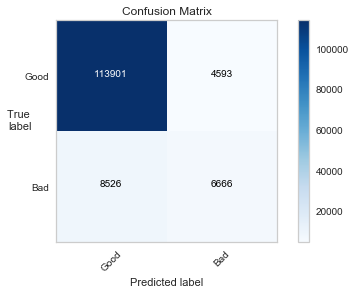

In [54]:
f.logreg_cm(logmodel, test_features, y_test, cm_labels=['Good', 'Bad'])

Although the accuracy is high, this is largely due to the imbalance between the offensive and non-offensive comments. The F1 score, while a better signifier, does not recognize the disproportionate cost of incorrectly-banned inoffensive comments. The cost function scores will better reflect our model's performance.

In order to see how the model predicts comments involving identity groups, we will run the same test, using only the portion of the test section with identity comments.

Confusion matrix, without normalization
Test Accuracy score:  0.8727282481859517
Test F1 score:  0.4937309929040175
Test Cost Function Score:  8557.795


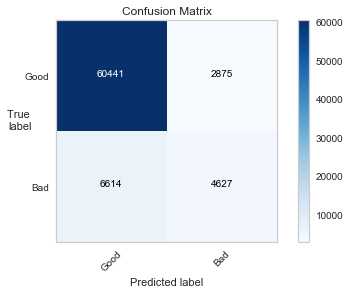

In [56]:
group_features, y_group = f.test_data_group(vectorizer, y_test, X, y)
f.logreg_cm(logmodel, group_features, y_group, cm_labels=['Good', 'Bad'])

In this instance, while the model still misclassifies a larger quantity of offensive comments than it correctly classifies, our main concern is the nearly 3000 inoffensive group comments that are incorrectly blocked

Moving forward, the cost function scores for both the overall test sections and the group test sections will be our baseline scores. However, for purposes of simplicity, we will use the F1 score to estimate the best model 

## Keras Multinary Deep-Learning Model

In order to reduce false 'offensive' flags on non-offensive identity group comments, we would like our next model to recognize which comments are 'identity group' comments and which aren't. In order to build a model that is better able to distinguish between group and non-group comments, we're going to make two changes.

First, we will use the multinary label describing both comment offensiveness and identity group content. Second, we are going to incorporate a Keras deep-learning model, instead of using a simple logistic regression.

Our first step is to create a tokenized list of the 6000 most common words from the entire dataset, convert these to an array of matrices, and convert each the tokenized comment texts to lists using these binary matrices. We will also one-hot encode the target variable.

In [5]:
one_hot_results, target_onehot = f.tokenizer_onehot(X, y)

In order to avoid overfitting our model to the prior test set, we will create new train and test sets. We will then use the test dataset index to separate the comment text and one-hot encoded target variables into training and test sets.

In [6]:
X_train, X_test, y_train, y_test = f.train_test(X,
                                                y['offensive_and_identity'],
                                                rs=24)
train, label_train, test, label_test = f.keras_prep(one_hot_results,
                                                    target_onehot, X_test)

Next, we will use the training data to fit a sequential Keras model. This model will contain five layers. For purposes of efficiency, the first four layers will use reLU to refine the 6000-word input to 50 variable estimations. Since the target will consist of four classifications, we will use softmax instead of sigmoid for the final layer.

We will use a 0.2 dropout between each layer to prevent overfitting. In addition, we will use 20% of the training model as a validation split.

In [15]:
model, results = f.keras_model(train, label_train, epoch=50)

Train on 217138 samples, validate on 54285 samples
Epoch 1/50
217138/217138 [==============================] - 33s 152us/step - loss: 1.0315 - f1_score: 0.3481 - val_loss: 0.9572 - val_f1_score: 0.5431
Epoch 2/50
217138/217138 [==============================] - 32s 148us/step - loss: 0.9051 - f1_score: 0.5874 - val_loss: 0.7954 - val_f1_score: 0.6962
Epoch 3/50
217138/217138 [==============================] - 32s 148us/step - loss: 0.7945 - f1_score: 0.6858 - val_loss: 0.6956 - val_f1_score: 0.7485
Epoch 4/50
217138/217138 [==============================] - 32s 148us/step - loss: 0.7397 - f1_score: 0.7194 - val_loss: 0.6642 - val_f1_score: 0.7577
Epoch 5/50
217138/217138 [==============================] - 32s 148us/step - loss: 0.7098 - f1_score: 0.7344 - val_loss: 0.6353 - val_f1_score: 0.7676
Epoch 6/50
217138/217138 [==============================] - 32s 148us/step - loss: 0.6897 - f1_score: 0.7429 - val_loss: 0.6139 - val_f1_score: 0.7736
Epoch 7/50
217138/217138 [=================

To determine whether the model is overfitting, we will plot the entropy loss and the F1 scores for both the train and validation samples at each epoch.

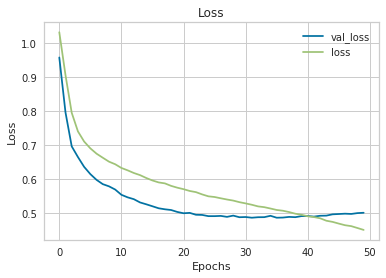

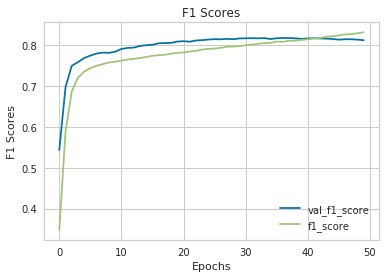

In [16]:
f.visualize_training_results(results)

We can determine from the graph that at epoch 40, the training dataset's entropy loss surpasses that of the validation dataset. Similarly, the F1-scores for the training and validation intersect at roughly the same point. This indicates that after epoch 40, the model has begun to overfit. We will repeat this model using only 40 epochs.

In [18]:
model, results = f.keras_model(train, label_train, epoch=40)

Train on 217138 samples, validate on 54285 samples
Epoch 1/40
217138/217138 [==============================] - 34s 154us/step - loss: 1.0382 - f1_score: 0.3230 - val_loss: 0.9720 - val_f1_score: 0.5131
Epoch 2/40
217138/217138 [==============================] - 33s 152us/step - loss: 0.9256 - f1_score: 0.5630 - val_loss: 0.8194 - val_f1_score: 0.6837
Epoch 3/40
217138/217138 [==============================] - 33s 152us/step - loss: 0.8094 - f1_score: 0.6769 - val_loss: 0.7070 - val_f1_score: 0.7433
Epoch 4/40
217138/217138 [==============================] - 33s 151us/step - loss: 0.7463 - f1_score: 0.7170 - val_loss: 0.6623 - val_f1_score: 0.7604
Epoch 5/40
217138/217138 [==============================] - 33s 152us/step - loss: 0.7151 - f1_score: 0.7323 - val_loss: 0.6339 - val_f1_score: 0.7687
Epoch 6/40
217138/217138 [==============================] - 33s 152us/step - loss: 0.6932 - f1_score: 0.7416 - val_loss: 0.6154 - val_f1_score: 0.7728
Epoch 7/40
217138/217138 [=================

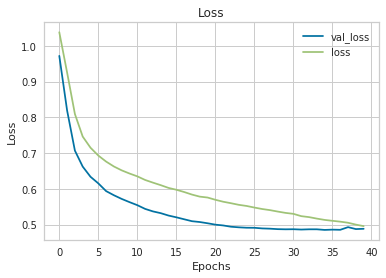

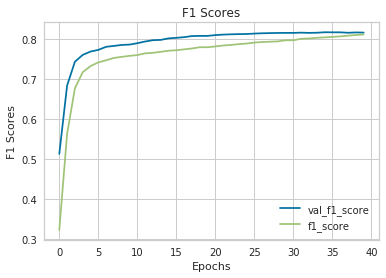

In [19]:
f.visualize_training_results(results)

We can see that in this model, the training and validation datasets don't diverge with respect to either their entropy loss or their F1-scores, indicating that we have minimized overfitting. We will now use this model to evaluate both the training and the test datasets.

In [20]:
f.model_evaluate(model, train, label_train, dataset='Training')

271423/271423 [==============================] - 26s 94us/step
Training Entrpy Loss: 0.37208294095771705
Training F1-Score: 0.8630973696708679


In [21]:
f.model_evaluate(model, test, label_test, dataset='Test')

133686/133686 [==============================] - 12s 93us/step
Test Entrpy Loss: 0.480229877409315
Test F1-Score: 0.8201864957809448


Our test F1-score has increased significantly. In order to fully understand this improvement, we will transform the target predictions and target labels into arrays. Then, we will create a confusion matrix of the results.

In [69]:
y_pred_classes, multi_label_test = f.prediction_keras(model, test, y_test)

Confusion matrix, without normalization


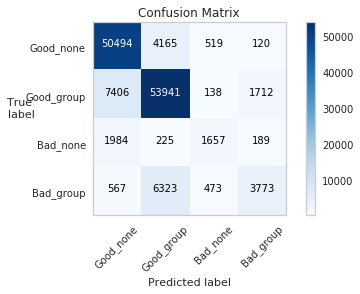

In [55]:
f.confusion_keras(y_pred_classes, multi_label_test)

The model shows excellent ability to distinguish between inoffensive non-group comments and inoffensive group comments, indicating a capacity to (at least somewhat) recognize group content. Likewise, when it correctly categorizes comments as offensive, it can usually determine whether they contain group content or not. However, we can still see a significant number of misclassifications. In order to determine the overall cost, we will convert these scores back to the original binary 'offensive/inoffensive' score, and use the custom cost function created earlier.

In [56]:
f.cost_function(multi_label_test, y_pred_classes, multinary=True)

6812.997

Given that the cost incurred by the original model was 12996.495, this model reduces the overall cost by nearly half. 

To isolate the effect on 'group' comments, we will create test datasets using only the 'group identity' comments within the original Keras test dataset, use this model to create target predictions, convert these to the original binary 'offensive/inoffensive' score, and evaluate the results using the custom cost function.

In [74]:
f.final_score(X_test, y_test, one_hot_results, target_onehot, model)

5767.3265

The cost, as applied only to 'group identity' comments, has decreased from 8557.795 to 5767.3265, indicating that the overall cost for 'group identity' comments has decreased significantly.

Based on these results, we can determine that the deep-learning model that uses both 'identity' and 'offensiveness' as a target drastically reduces false 'offensive' classifications, without a drastic decrease in either true 'offensive' or 'inoffensive' classifications. Likewise, it does not cause a drastic increase in false 'inoffensive' classifications.